In [99]:
# 匯入必要套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# 1. 資料讀取
df = pd.read_csv('Automobile_data.csv')

In [100]:
# 2. 資料理解
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [101]:
# 3. 資料前處理
# 用平均值/眾數補空缺，或直接刪除缺失多的欄位
df = df.replace('?', np.nan)
df = df.dropna(subset=['price'])
df['price'] = df['price'].astype(float)
# 類別型特徵補眾數
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# 數值型特徵補均值
for col in df.select_dtypes(exclude='object').columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 確認類型一致
    df[col] = df[col].fillna(df[col].mean())

# 類別型特徵處理
df = pd.get_dummies(df, drop_first=True)

In [102]:
# 4. 特徵選擇
X = df.drop(['price'], axis=1)
y = df['price']
selector = SelectKBest(score_func=f_regression, k=24)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("選中特徵:", selected_features)

選中特徵: Index(['wheel-base', 'length', 'width', 'curb-weight', 'engine-size',
       'city-mpg', 'highway-mpg', 'normalized-losses_161', 'make_bmw',
       'make_jaguar', 'make_mercedes-benz', 'drive-wheels_fwd',
       'drive-wheels_rwd', 'engine-type_ohc', 'engine-type_ohcv',
       'num-of-cylinders_four', 'num-of-cylinders_six', 'fuel-system_2bbl',
       'fuel-system_mpfi', 'bore_3.8', 'horsepower_182', 'horsepower_184',
       'peak-rpm_4750', 'peak-rpm_5900'],
      dtype='object')


In [103]:
# 5. 建模與預測
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [104]:
# 6. 模型評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, RMSE: {rmse}, R²: {r2}')

MSE: 12663837.774396218, RMSE: 3558.6286367639177, R²: 0.8964922616648232


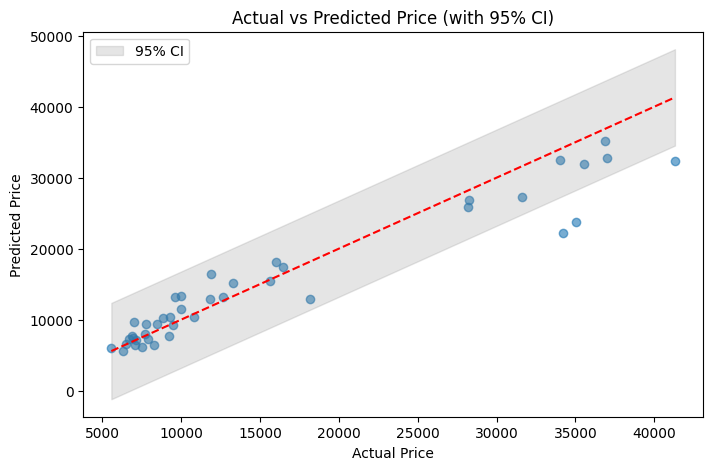

In [105]:
# 視覺化(含95%信賴區間)
import scipy.stats as st
pred_std = np.std(y_pred - y_test)
ci = 1.96 * pred_std
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.fill_between([y_test.min(), y_test.max()],
                 [y_test.min()+ci, y_test.max()+ci],
                 [y_test.min()-ci, y_test.max()-ci],
                 color='gray', alpha=0.2, label="95% CI")
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (with 95% CI)')
plt.legend()
plt.show()